In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

# Load datasets, skipping the second row (units)
zhaw_data = pd.read_csv('../data/datazhawfull.csv', skiprows=[1])
zhaw_metadata = pd.read_csv('../data/datazhawfull_meta.csv', skiprows=[1])
agroscope_data = pd.read_csv('../data/dataagro24_run1.csv', skiprows=[1])
agroscope_metadata = pd.read_csv('../data/dataagro24_run1_meta.csv', skiprows=[1])

# Merge ZHAW data and metadata, then sort by timestring
zhaw_combined = pd.merge(zhaw_data, zhaw_metadata, on='timestring', how='outer')
zhaw_combined['timestring'] = pd.to_datetime(zhaw_combined['timestring'])
zhaw_combined = zhaw_combined.sort_values('timestring').reset_index(drop=True)

# Merge Agroscope data and metadata, then sort by timestring
agroscope_combined = pd.merge(agroscope_data, agroscope_metadata, on='timestring', how='outer')
agroscope_combined['timestring'] = pd.to_datetime(agroscope_combined['timestring'])
agroscope_combined = agroscope_combined.sort_values('timestring').reset_index(drop=True)

# Find the pH column (case-insensitive)
ph_col = next((col for col in agroscope_combined.columns if col.strip().lower() == 'ph'), None)

# Initialize CO2 column
co2_values = [0]  # First row has no previous value

for i in range(1, len(agroscope_combined)):
    co2 = 0
    curr_ph = agroscope_combined.iloc[i][ph_col]
    prev_ph = agroscope_combined.iloc[i - 1][ph_col]
    curr_time = agroscope_combined.iloc[i]['timestring']
    prev_time = agroscope_combined.iloc[i - 1]['timestring']
    # Check for valid pH values
    if pd.notnull(curr_ph) and pd.notnull(prev_ph):
        try:
            curr_ph = float(curr_ph)
            prev_ph = float(prev_ph)
            if curr_ph < prev_ph:
                minutes = abs((curr_time - prev_time).total_seconds() / 60)
                co2 = 2 * minutes if minutes < 5 else 0
        except ValueError:
            pass
    co2_values.append(co2)

agroscope_combined['CO2'] = co2_values

# Interpolate Agroscope DW
dw_mask = agroscope_combined['DW'].notnull()
dw_times = agroscope_combined.loc[dw_mask, 'timestring'].astype(np.int64) // 10**9  # seconds
dw_values = agroscope_combined.loc[dw_mask, 'DW']

if len(dw_times) > 1:
    cs_dw = CubicSpline(dw_times, dw_values)
    agroscope_combined['DW_fitted'] = cs_dw(agroscope_combined['timestring'].astype(np.int64) // 10**9)
else:
    agroscope_combined['DW_fitted'] = np.nan

# Interpolate ZHAW Trockenmasse
tm_mask = zhaw_combined['Trockenmasse'].notnull()
tm_times = zhaw_combined.loc[tm_mask, 'timestring'].astype(np.int64) // 10**9  # seconds
tm_values = zhaw_combined.loc[tm_mask, 'Trockenmasse']

if len(tm_times) > 1:
    cs_tm = CubicSpline(tm_times, tm_values)
    zhaw_combined['Trockenmasse_fitted'] = cs_tm(zhaw_combined['timestring'].astype(np.int64) // 10**9)
else:
    zhaw_combined['Trockenmasse_fitted'] = np.nan

/var/folders/3f/rmlym6q17_l_vn93by_0w8xw0000gn/T/ipykernel_67819/762779238.py:15: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S.%f format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  zhaw_combined['timestring'] = pd.to_datetime(zhaw_combined['timestring'])
/var/folders/3f/rmlym6q17_l_vn93by_0w8xw0000gn/T/ipykernel_67819/762779238.py:20: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S.%f format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  agroscope_combined['timestring'] = pd.to_datetime(agroscope_combined['timestring'])


In [72]:
# Display the first few rows of the combined datasets
print('Combined ZHAW Data:')
print(zhaw_combined.head())

Combined ZHAW Data:
           timestring  FLOW.OF.ALGAE  FLOW.OF.CO2      PAR.1      PAR.2  \
0 2024-05-14 14:50:00      18.501160     0.381944  346.35420  546.87500   
1 2024-05-14 15:00:00      18.357059     0.401042  418.31598  546.26737   
2 2024-05-14 15:10:00      17.984954     0.410590  482.55211  613.02086   
3 2024-05-14 15:20:00      18.079282     0.412326  394.79168  523.09031   
4 2024-05-14 15:30:00      17.515046     0.540220  180.55555  318.31598   

    PRESSURE      SPEED  SUM.OF.WATER  TEMPERATURE  THICKNESS.OF.ALGAE  ...  \
0  16.371530  92.355050      2006.957    29.050930            5.711732  ...   
1  16.086807  91.887289      2006.957    29.007525            5.980356  ...   
2  15.854168  90.733541      2006.957    29.117478            6.047389  ...   
3  15.961807  91.085994      2006.957    29.129053            5.943264  ...   
4  15.430556  89.440599      2006.957    28.521411            6.066297  ...   

   N in Algen und Medium  N recovered  N im Medium  N 

In [73]:
print('\nCombined Agroscope Data:')
print(agroscope_combined.head())


Combined Agroscope Data:
               timestring    pH  Temperature    PAR  LightOut  Actuators  \
0 2024-04-26 12:00:00.000   NaN          NaN    NaN       NaN        NaN   
1 2024-04-26 14:01:51.720  7.34         21.7  339.0      50.0        7.0   
2 2024-04-26 14:02:47.369  7.34         21.7  350.0      50.0        7.0   
3 2024-04-26 14:03:20.684  7.34         21.7  362.0      50.0        7.0   
4 2024-04-26 14:03:50.401  7.34         21.7  374.0      50.0        7.0   

        DW Comments  NH4-N  PO4-P  CO2  DW_fitted  
0  0.09768      NaN   97.0   28.7  0.0   0.097680  
1      NaN      NaN    NaN    NaN  0.0   0.171458  
2      NaN      NaN    NaN    NaN  0.0   0.171997  
3      NaN      NaN    NaN    NaN  0.0   0.172314  
4      NaN      NaN    NaN    NaN  0.0   0.172603  


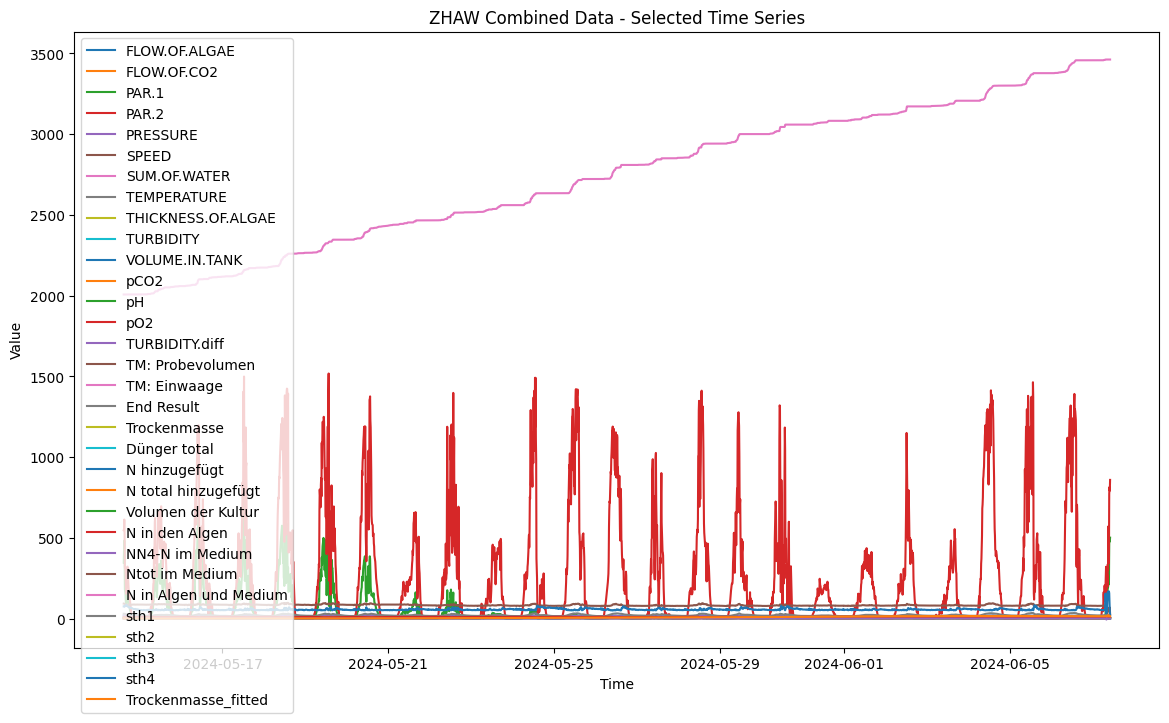

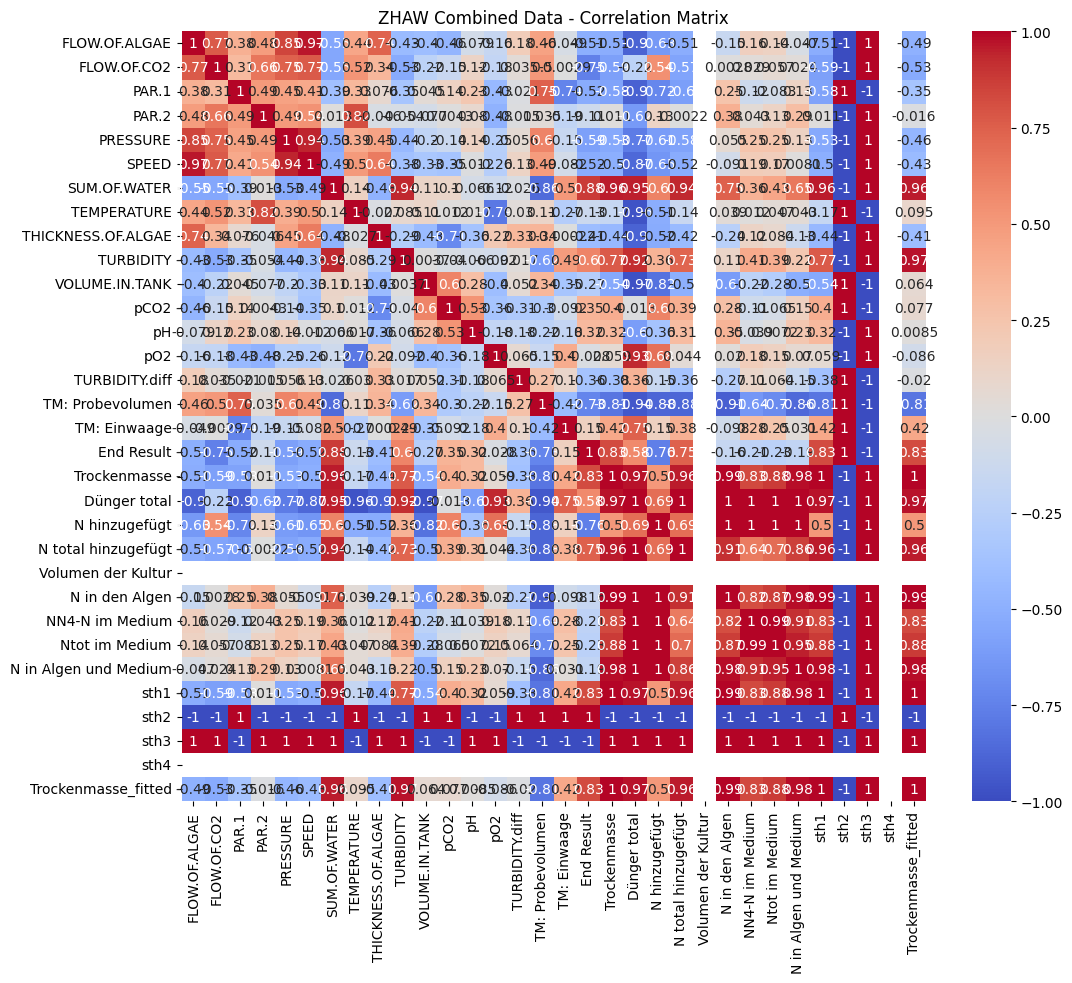

In [84]:
# Plot time series for a few selected columns (replace with your actual column names)

selected_columns = [
    col for col in zhaw_combined.columns[1:]
    if isinstance(col, str) and np.issubdtype(zhaw_combined[col].dtype, np.number)
]

plt.figure(figsize=(14, 8))
for col in selected_columns:
    plt.plot(zhaw_combined['timestring'], zhaw_combined[col], label=col)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ZHAW Combined Data - Selected Time Series')
plt.legend()
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(12, 10))
corr = zhaw_combined.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('ZHAW Combined Data - Correlation Matrix')
plt.show()

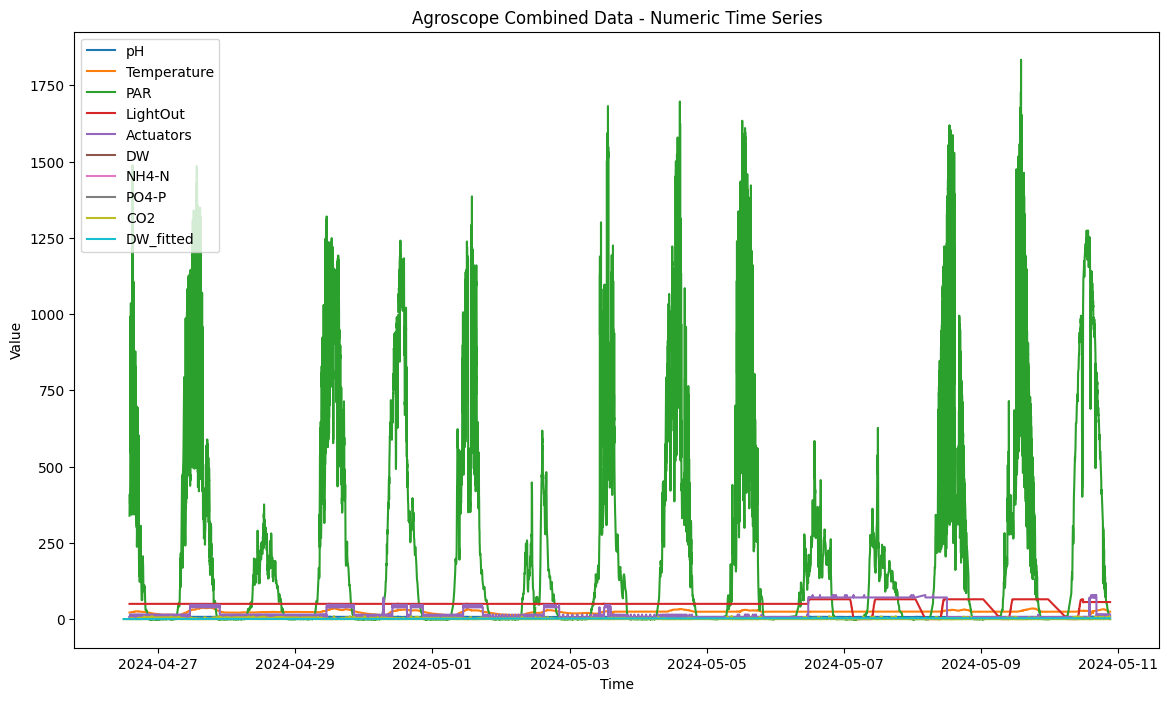

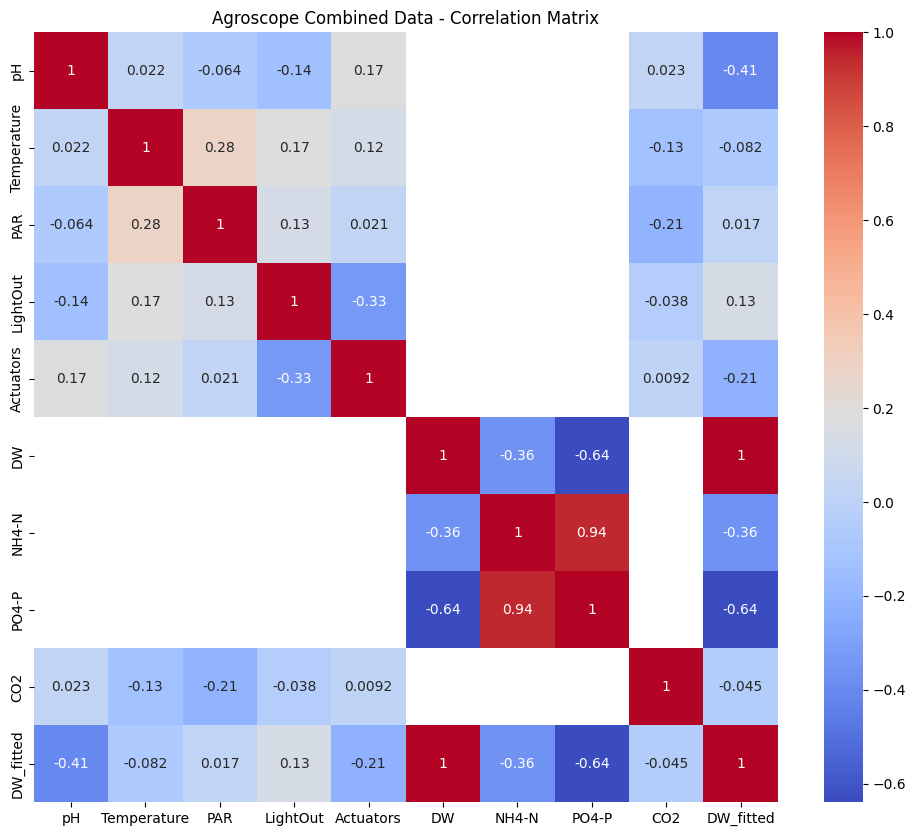

In [81]:
# Repeat for Agroscope data
# Select only numeric columns except 'timestring'
selected_columns = [
    col for col in agroscope_combined.columns[1:]
    if isinstance(col, str) and np.issubdtype(agroscope_combined[col].dtype, np.number)
]

plt.figure(figsize=(14, 8))
for col in selected_columns:
    plt.plot(agroscope_combined['timestring'], agroscope_combined[col], label=col)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Agroscope Combined Data - Numeric Time Series')
plt.legend()
plt.show()

plt.figure(figsize=(12, 10))
corr = agroscope_combined.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Agroscope Combined Data - Correlation Matrix')
plt.show()

In [78]:
agroscope_combined.describe()

,timestring,pH,Temperature,PAR,LightOut,Actuators,DW,NH4-N,PO4-P,CO2,DW_fitted
count,43500,43492.000000,43492.000000,43492.000000,43492.000000,43492.000000,8.000000,5.00000,5.000000,43500.000000,43500.000000
mean,2024-05-03 17:57:20.812253696,7.258256,28.026966,713.174308,51.722892,21.733859,1.570354,53.60000,15.500000,0.135660,1.917887
min,2024-04-26 12:00:00,4.340000,6.600000,-2.000000,0.000000,0.000000,0.097680,15.00000,5.000000,0.000000,0.097680
25%,2024-04-29 13:00:37.935750144,7.070000,24.600000,466.000000,50.000000,7.000000,0.747565,34.00000,11.500000,0.000000,0.620868
50%,2024-05-04 12:50:23.858500096,7.340000,28.500000,717.000000,50.000000,7.000000,1.649660,52.00000,15.000000,0.000000,2.575722
75%,2024-05-08 09:59:39.888250112,7.430000,31.100000,964.250000,50.000000,39.000000,2.328132,70.00000,17.300000,0.038958,2.784675
max,2024-05-10 21:05:37.391000,8.620000,37.800000,1834.000000,72.000000,79.000000,2.878240,97.00000,28.700000,9.882967,2.890455
std,NaN,0.262863,4.430718,348.110427,11.125706,20.716498,1.025449,31.73799,8.717511,0.629819,0.999958


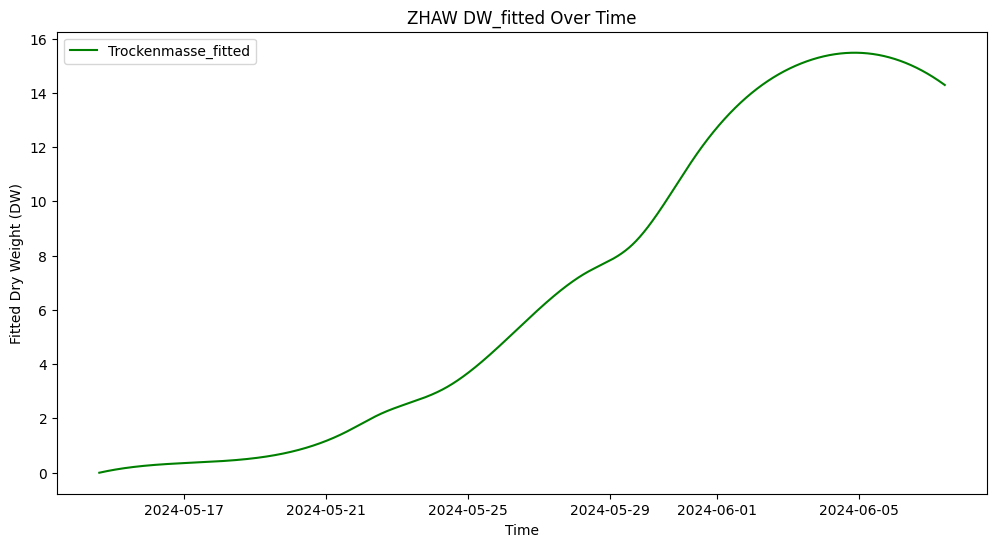

In [88]:
# Plot only the fitted dry weight for ZHAW
plt.figure(figsize=(12, 6))
plt.plot(zhaw_combined['timestring'], zhaw_combined['Trockenmasse_fitted'], label='Trockenmasse_fitted', color='green')
plt.xlabel('Time')
plt.ylabel('Fitted Dry Weight (DW)')
plt.title('ZHAW DW_fitted Over Time')
plt.legend()
plt.show()

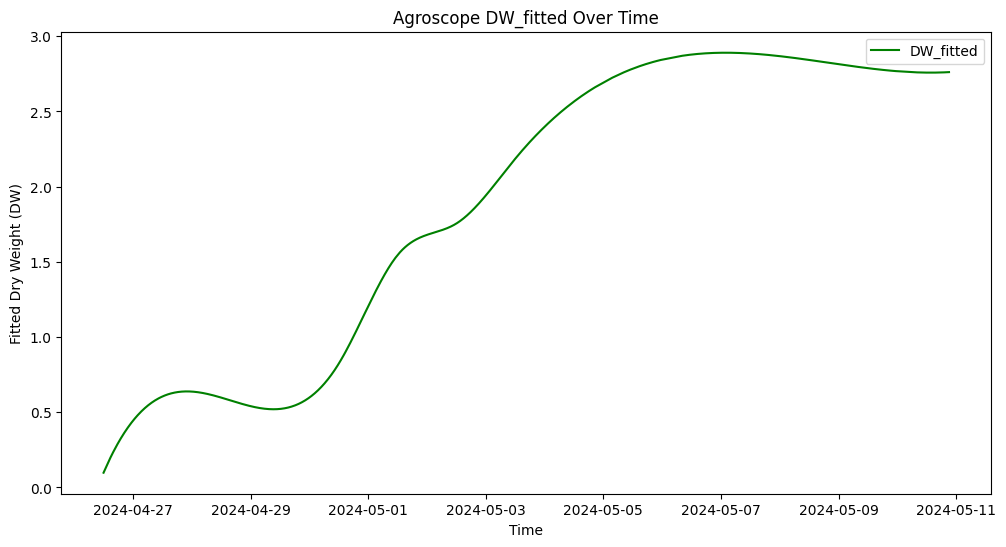

In [86]:
# Plot only the fitted dry weight for Agroscope
plt.figure(figsize=(12, 6))
plt.plot(agroscope_combined['timestring'], agroscope_combined['DW_fitted'], label='DW_fitted', color='green')
plt.xlabel('Time')
plt.ylabel('Fitted Dry Weight (DW)')
plt.title('Agroscope DW_fitted Over Time')
plt.legend()
plt.show()